## **Features in the DataFrame**  
**(with Notes on Usefulness)**

- **attendanceMandatory** - ➖ Maybe useful, but lots of nulls  
- **clarityRating** - ❌ Outdated  
- **class** - ➖ Useful for class analysis (maybe in v2 or v3 of the dashboard)  
- **comment** - ✅ Useful  
- **createdByUser** - ❌ Useless  
- **date** - ✅ Time series data  
- **difficultyRating** - ✅ Useful  
- **grade** - ✅ Useful  
- **helpfulRating** - ❌ Outdated, specific to review  
- **isForCredit** - ➖ Maybe useful  
- **isForOnlineClass** - ➖ Maybe useful  
- **qualityRating** - ✅ Useful  
- **ratingTags** - ✅➖ Maybe useful, can show trends because they're standardized  
- **textbookUse** - ➖ Maybe useful  
- **thumbsDownTotal** - Only useful for specific reviews  
- **thumbsUpTotal** - Only useful for specific reviews  
- **wouldTakeAgain** - ✅ Useful  
- **pid** - ❌ Implied data  

### **V2 (Intermediate)**
- **Interaction score**  ✅
  - (Display score) - Something with thumbs ups, thumbs downs, and number of comments- based on size of school
- **Extractive summary of comments** ✅
- **Filter by class** (with overall class analysis) Frontend-wise ➖ 
- **Median grade in class** (Note: may be skewed as reviewers are more likely to be those who did well or terribly) ✅
- **Review volume trends** (Are reviews increasing or decreasing over time?)  ✅ (Done in V1)
- **Rating tags score** ✅
- **Red flags analysis**
  - 'Our' Score
  - Combination of low ratings + specific tags  
- **Basic Sentiment Analysis** 

### **V2 (Intermediate)**
- **Department-level comparisons across universities**  
- **Gender analysis in ratings** (Generate by guess of first name)  
- **Course level distribution** (Intro vs advanced courses)  
- **Online vs In-person teaching effectiveness**  
- **University ranking correlation with ratings**  
- **Seasonal trends across universities**
- **Apply original overall to university page**
- **Overall Basic Sentiment Analysis**


In [9]:
import base64
import time
import requests

def get_all_reviews(professor_id):
    headers = {
        'Authorization': 'Basic dGVzdDp0ZXN0',
        'Content-Type': 'application/json',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # Encode the professor_id in base64
    encoded_professor_id = base64.b64encode(f"Teacher-{professor_id}".encode()).decode()
    
    rev_list = []
    has_next_page = True
    end_cursor = None
    
    while has_next_page:
        # Add the after parameter if we have an end cursor
        ratings_params = "first: 1000"
        if end_cursor:
            ratings_params += f', after: "{end_cursor}"'
            
        payload = {
            "query": f"""query GetTeacherRatings($id: ID!) {{
                node(id: $id) {{
                    ... on Teacher {{
                        id firstName lastName
                        school {{ id name }}
                        ratings({ratings_params}) {{
                            edges {{
                                node {{
                                    comment class difficultyRating qualityRating
                                    attendanceMandatory wouldTakeAgain
                                    isForCredit textbookUse date grade ratingTags clarityRating
                                    helpfulRating isForOnlineClass thumbsUpTotal thumbsDownTotal
                                }}
                            }}
                            pageInfo {{
                                hasNextPage
                                endCursor
                            }}
                        }}
                    }}
                }}
            }}""",
            "variables": {
                "id": encoded_professor_id
            }
        }
        
        response = requests.post(
            "https://www.ratemyprofessors.com/graphql",
            json=payload,
            headers=headers
        )
        if response.status_code == 429:
            print("Rate limit exceeded, waiting 10 seconds before retrying...")
            time.sleep(10)
            continue

        if response.status_code == 503:
            print("Rate limit exceeded, waiting 10 seconds before retrying...")
            time.sleep(10)
            continue
        
        if response.status_code != 200:
            print(f"Error: Status code {response.status_code}")
            print(response.text)
            return None
            
        data = response.json()
        
        # Check for errors in the response
        if 'errors' in data:
            print("GraphQL Errors:", data['errors'])
            return None
            
        print(data['data']['node']['school']['id'])
        node_list = data['data']['node']['ratings']['edges']
        page_info = data['data']['node']['ratings']['pageInfo']
        
        # Add professor_id to each review and append to results
        for node in node_list:
            node['node']['pid'] = professor_id
            rev_list.append(node['node'])
            
        # Update pagination info
        has_next_page = page_info['hasNextPage']
        end_cursor = page_info['endCursor']
        
        # Add a small delay between requests
        if has_next_page:
            time.sleep(0.5)
    return rev_list, data['data']['node']['school']['name']

import pandas as pd

reviews, school_name = get_all_reviews(2936075) # 1918813 2936075
df = pd.DataFrame(reviews)

# Remove '+0000 UTC' from date strings and replace with Nothing
df['date'] = df['date'].str.replace('+0000 UTC', 'UTC')
df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S UTC')

display(df)


U2Nob29sLTE1MTM=


,attendanceMandatory,clarityRating,class,comment,date,difficultyRating,grade,helpfulRating,isForCredit,isForOnlineClass,qualityRating,ratingTags,textbookUse,thumbsDownTotal,thumbsUpTotal,wouldTakeAgain,pid,datetime
0,,1,CS575,"Didn't offer a make-up exam for the midterm, w...",2025-01-15 21:34:45 UTC,5,D+,1,True,False,1,Tough grader--Graded by few things,NaN,0,0,NaN,2936075,2025-01-15 21:34:45
1,mandatory,1,CS575,"If you can avoid him, please do. As said befor...",2024-12-21 02:15:43 UTC,5,Not sure yet,1,True,False,1,Tough grader--Lots of homework--Test heavy,-1.0,0,0,NaN,2936075,2024-12-21 02:15:43
2,mandatory,1,CS575,Mark Wilson's problem is that he doesn't expla...,2024-12-11 00:10:36 UTC,5,Not sure yet,1,True,False,1,Test heavy--Graded by few things,-1.0,0,0,NaN,2936075,2024-12-11 00:10:36
3,non mandatory,1,COMPSCI240,Brags about how many students fail his exams. ...,2024-11-18 14:18:29 UTC,5,B+,1,True,False,1,Tough grader--Lots of homework--Test heavy,-1.0,0,0,NaN,2936075,2024-11-18 14:18:29
4,non mandatory,1,CS240,If you're lucky enough to avoid 240 or any cla...,2024-11-18 14:11:57 UTC,5,A-,1,True,False,1,Tough grader--Lots of homework--Test heavy,-1.0,0,0,NaN,2936075,2024-11-18 14:11:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,non mandatory,1,CS240,Extremely rude and insulting to students. Atte...,2023-11-10 04:34:18 UTC,5,B,1,True,False,1,Tough grader--Lecture heavy--Test heavy,3.0,1,15,NaN,2936075,2023-11-10 04:34:18
104,non mandatory,1,CS240,Demands respect from students while often not ...,2023-10-31 21:42:03 UTC,4,,1,True,False,1,Tough grader--Test heavy--Graded by few things,-1.0,1,17,NaN,2936075,2023-10-31 21:42:03
105,,1,CS240,Professor Wilson just reads off slides and doe...,2023-10-23 19:10:56 UTC,4,Incomplete,1,False,False,1,,NaN,1,15,NaN,2936075,2023-10-23 19:10:56
106,non mandatory,1,CS240,"Professor Wilson is condescending, Could not c...",2023-10-20 23:04:40 UTC,4,Incomplete,1,True,False,1,,-1.0,1,17,NaN,2936075,2023-10-20 23:04:40



School Information for University of Massachusetts - Amherst:
Official Name: University of Massachusetts-Amherst
City: Amherst
State: MA
School URL: www.umass.edu/

Size-Related Statistics:
Total Student Population: 24,111
Undergraduate Enrollment (12-month): 27,531
Graduate Enrollment (12-month): 9,341
Male Students: 48.6%
Female Students: 51.4%
Full-time Student Retention Rate: 90.3%
Completion/Graduation Rate: 83.4%

Additional Statistics:
Admission Rate: 63.5%
In-state Tuition: $16,952
Out-of-state Tuition: $38,171


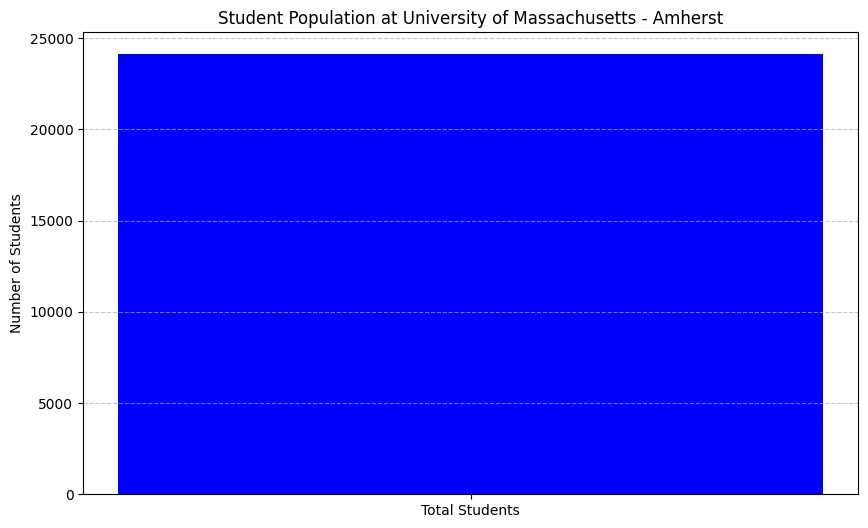

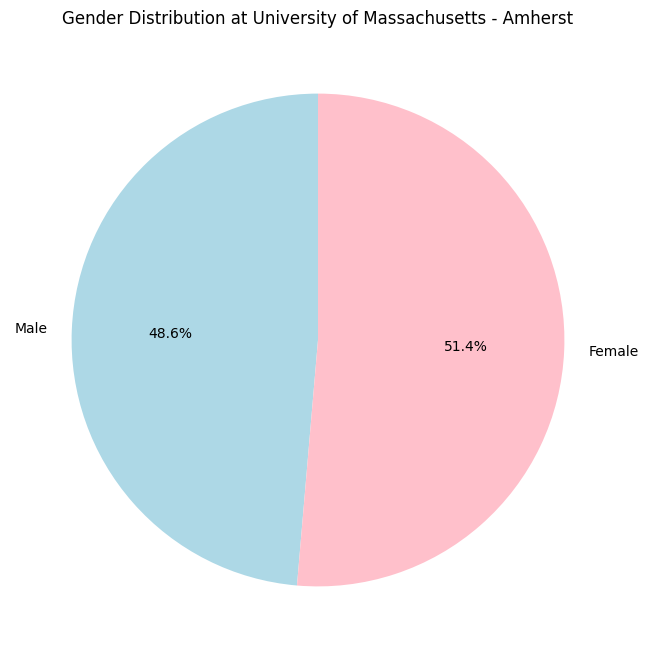

In [10]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

# Function to query the College Scorecard API for school information
def get_college_data(school_name):
    """
    Query the College Scorecard API for information about a specific school.
    
    Args:
        school_name (str): The name of the school to search for
        
    Returns:
        dict: School data if found, None otherwise
    """
    # Direct URL with all parameters included
    url = f"https://api.data.gov/ed/collegescorecard/v1/schools?api_key=3PorPPRdmNK1u89oUzP1v3ytOX7M4Df5CPdGFa5C&school.name={school_name}&fields=id,school.name,school.city,school.state,school.school_url,latest.student.size,latest.student.enrollment.undergrad_12_month,latest.student.enrollment.grad_12_month,latest.admissions.admission_rate.overall,latest.cost.tuition.in_state,latest.cost.tuition.out_of_state,latest.student.demographics.men,latest.student.demographics.women,latest.student.retention_rate.four_year.full_time,latest.completion.rate&per_page=1&sort=latest.student.size:desc"
    
    try:
        # Make the API request
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            
            # Check if any results were found
            if data['metadata']['total'] > 0:
                return data
            else:
                print(f"No data found for school: {school_name}")
                return None
        else:
            print(f"Error: Status code {response.status_code}")
            print(response.text)
            return None
            
    except Exception as e:
        print(f"Error querying College Scorecard API: {e}")
        return None

# Query the API with the school name we got from the professor data
college_data = get_college_data(school_name)

# Store school size and related metrics
school_size_data = {}

# Display the results if data was found
if college_data and college_data['results']:
    # Get the first result (most relevant match)
    school_info = college_data['results'][0]
    
    # Extract and display key information
    print(f"\nSchool Information for {school_name}:")
    print(f"Official Name: {school_info.get('school.name', 'N/A')}")
    print(f"City: {school_info.get('school.city', 'N/A')}")
    print(f"State: {school_info.get('school.state', 'N/A')}")
    print(f"School URL: {school_info.get('school.school_url', 'N/A')}")
    
    # Extract size-related data
    print("\nSize-Related Statistics:")
    
    # Total student population
    if 'latest.student.size' in school_info:
        student_size = school_info['latest.student.size']
        school_size_data['total_students'] = student_size
        print(f"Total Student Population: {student_size:,}")
    
    # Undergraduate and graduate enrollment
    if 'latest.student.enrollment.undergrad_12_month' in school_info:
        undergrad = school_info['latest.student.enrollment.undergrad_12_month']
        school_size_data['undergrad_students'] = undergrad
        print(f"Undergraduate Enrollment (12-month): {undergrad:,}")
    
    if 'latest.student.enrollment.grad_12_month' in school_info:
        grad = school_info['latest.student.enrollment.grad_12_month']
        school_size_data['grad_students'] = grad
        print(f"Graduate Enrollment (12-month): {grad:,}")
    
    # Gender distribution
    if 'latest.student.demographics.men' in school_info:
        men_pct = school_info['latest.student.demographics.men']
        school_size_data['men_percentage'] = men_pct
        print(f"Male Students: {men_pct*100:.1f}%")
    
    if 'latest.student.demographics.women' in school_info:
        women_pct = school_info['latest.student.demographics.women']
        school_size_data['women_percentage'] = women_pct
        print(f"Female Students: {women_pct*100:.1f}%")
    
    # Retention rates (indicator of school quality/satisfaction)
    if 'latest.student.retention_rate.four_year.full_time' in school_info:
        full_time_retention = school_info['latest.student.retention_rate.four_year.full_time']
        school_size_data['retention_rate'] = full_time_retention
        print(f"Full-time Student Retention Rate: {full_time_retention*100:.1f}%")
    
    # Completion/graduation rate
    if 'latest.completion.rate_suppressed.overall' in school_info:
        completion_rate = school_info['latest.completion.rate_suppressed.overall']
        school_size_data['completion_rate'] = completion_rate
        print(f"Completion/Graduation Rate: {completion_rate*100:.1f}%")
    
    # Other relevant statistics
    print("\nAdditional Statistics:")
    if 'latest.admissions.admission_rate.overall' in school_info:
        admission_rate = school_info['latest.admissions.admission_rate.overall']
        school_size_data['admission_rate'] = admission_rate
        print(f"Admission Rate: {admission_rate*100:.1f}%")
    
    if 'latest.cost.tuition.in_state' in school_info:
        in_state = school_info['latest.cost.tuition.in_state']
        school_size_data['in_state_tuition'] = in_state
        print(f"In-state Tuition: ${in_state:,}")
    
    if 'latest.cost.tuition.out_of_state' in school_info:
        out_state = school_info['latest.cost.tuition.out_of_state']
        school_size_data['out_of_state_tuition'] = out_state
        print(f"Out-of-state Tuition: ${out_state:,}")

    # Create a DataFrame from the collected data
    school_df = pd.DataFrame([school_size_data])
    
    # Plot some size-related metrics if available
    if 'total_students' in school_size_data:
        plt.figure(figsize=(10, 6))
        plt.bar(['Total Students'], [school_size_data['total_students']], color='blue')
        plt.title(f'Student Population at {school_name}')
        plt.ylabel('Number of Students')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        
    # If we have gender distribution, create a pie chart
    if 'men_percentage' in school_size_data and 'women_percentage' in school_size_data:
        plt.figure(figsize=(8, 8))
        plt.pie([school_size_data['men_percentage'], school_size_data['women_percentage']], 
                labels=['Male', 'Female'], 
                autopct='%1.1f%%',
                colors=['lightblue', 'pink'],
                startangle=90)
        plt.title(f'Gender Distribution at {school_name}')
        plt.show()


In [11]:
print(school_size_data['total_students'])
school_size_multplier = 1
if school_size_data['total_students'] > 30000:
    school_size_multplier = 0.25
elif school_size_data['total_students'] > 15000:
    school_size_multplier = 0.5
elif school_size_data['total_students'] > 7500:
    school_size_multplier = 0.75
elif school_size_data['total_students'] > 3750:
    school_size_multplier = 0.9
else:
    school_size_multplier = 1

#arbitrarily set. TODO: find mean and std deviation of university size

'''
now i want to take the interval where 80% of the reviews are. This will allow us to see the interaction score.
This will allow us to see the number of reviews that are within the interval of when a teacher was teaching, 
and not provide bias since they taught a long time ago. We are looking for the frequency of reviews within the time
interval of when they were teaching the most.
We only need to do this if we have a large sample size, aka >20 reviews
Higher score means really frequent reviews in a short time period, which is scaled by the school size.
'''
def get_interaction_score(df):
    
    lower_bound, upper_bound = 0.1, 0.9
    df = df.sort_values(by='datetime')
    total_reviews = len(df)
    lower_index, upper_index = int(lower_bound * total_reviews), int(upper_bound * total_reviews)
    interval_reviews = df.iloc[lower_index:upper_index]
    
    
    min_date, max_date = interval_reviews['datetime'].min(), interval_reviews['datetime'].max()
    days = (max_date - min_date).days / 30
    #calculate the number of reviews per month, and multiply by school size multiplier
    reviews_per_month = len(interval_reviews) / days
    return reviews_per_month * school_size_multplier

print(get_interaction_score(df))




24111
4.6113074204946995


In [12]:
def get_mapping_for_professor(reviews, verbose=1):
    # Extract only needed columns and filter out non-string class values early
    reviews = reviews[['pid', 'class']]
    reviews = reviews[reviews['class'].apply(lambda x: isinstance(x, str))]
    
    if reviews.empty:
        return None, False
    
    # Check if all professor IDs are the same
    first_pid = reviews['pid'].iloc[0]
    all_same_pid = (reviews['pid'] == first_pid).all()
    
    if not all_same_pid:
        if verbose:
            print(f"Warning: Not all reviews have the same professor ID. Found {reviews['pid'].nunique()} unique professor IDs.")
        return None, False
    
    # Get class list once and pass over the class list once
    class_list = reviews['class'].dropna().tolist()
    total_classes = len(class_list)
    # If no classes, return early
    if total_classes == 0:
        if verbose:
            print("No classes found.")
        return {'misc': {'list': class_list}}, False
    
    unique_classes = reviews['class'].unique()
    counts = {}
    for class_name in class_list:
        digits = len(''.join(filter(str.isdigit, class_name)))
        counts[digits] = counts.get(digits, 0) + 1
    
    # Check for majority digit count
    majority_threshold = 0.6
    majority_digit_count = None
    
    for digits, count in counts.items():
        percentage = count / total_classes
        if percentage > majority_threshold:
            majority_digit_count = digits
            if verbose:
                print(f"Found a majority digit count: {digits} digits (appears in {count}/{total_classes} classes, {percentage:.2%})")
            break
    
    # If no clear majority, determine best approach
    if majority_digit_count is None:
        if verbose:
            print(f"No majority digit count found. Distribution: {counts}")
        
        # Count class occurrences, now for overall reviews
        class_counts = {}
        for class_name in class_list:
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        # Find classes with >10% occurrence in overall reviews
        threshold = 0.1 * total_classes
        significant_classes = {cls: count for cls, count in class_counts.items() if count >= threshold}
        
        if significant_classes:
            if verbose:
                print(f"Found {len(significant_classes)} classes with >10% of reviews")
            
            # Create class mapping with significant classes and misc
            class_mapping = {}
            for cls in significant_classes:
                class_mapping[cls] = {'list': [cls]}
            
            # Add all other classes to misc
            misc_classes = [cls for cls in class_list if cls not in significant_classes]
            class_mapping['misc'] = {'list': misc_classes}
            
            return class_mapping, True
        else:
            if verbose:
                print("No classes with >10% of reviews found, using most common digit count")
            
            # Determine digit count to use
            majority_digit_count = 3 if counts.get(3, 0) > 0 else max(counts.items(), key=lambda x: x[1])[0] if counts else None
    
    # Initialize class mapping
    class_mapping = {'misc': {'list': []}}
    
    # Special handling for zero-digit case
    if majority_digit_count == 0:
        # Count class occurrences for threshold calculation
        class_counts = {}
        for class_name in class_list:
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        # Find classes with >10% occurrence
        threshold = 0.1 * total_classes
        significant_classes = {cls: count for cls, count in class_counts.items() if count >= threshold}
        
        # Extract alpha-only versions of class names
        alpha_only_classes = {}
        for class_name in unique_classes:
            alpha_only = ''.join(filter(str.isalpha, class_name.upper()))
            if alpha_only:
                alpha_only_classes[class_name] = alpha_only
            else:
                class_mapping['misc']['list'].append(class_name)
        
        # Group classes by substring containment
        grouped = {}
        ungrouped = set(alpha_only_classes.keys())
        
        # Sort by length descending to prioritize longer strings as group labels
        sorted_classes = sorted(alpha_only_classes.keys(), key=lambda x: len(alpha_only_classes[x]), reverse=True)
        
        for potential_group in sorted_classes:
            if potential_group not in ungrouped:
                continue
                
            alpha_potential = alpha_only_classes[potential_group]
            group_members = [potential_group]
            ungrouped.remove(potential_group)
            
            # Find all classes that are substrings (in order) of this one
            for other_class in list(ungrouped):
                alpha_other = alpha_only_classes[other_class]
                
                # Check if letters from other_class appear in the same order in potential_group
                i, j = 0, 0
                while i < len(alpha_other) and j < len(alpha_potential):
                    if alpha_other[i] == alpha_potential[j]:
                        i += 1
                    j += 1
                
                if i == len(alpha_other):  # All letters found in order
                    group_members.append(other_class)
                    ungrouped.remove(other_class)
            
            # Use the class name as key if it has >10% reviews, otherwise use the alpha string
            group_key = potential_group
            if not any(cls in significant_classes for cls in group_members):
                if len(group_members) == 1:
                    class_mapping['misc']['list'].extend(group_members)
                    continue
                
            grouped[group_key] = group_members
        
        # Add grouped classes to mapping
        for group_key, group_members in grouped.items():
            class_mapping[group_key] = {'list': group_members, 'prefix': '', 'suffix': ''}

        return class_mapping, True #no need to do prefix or suffix as only strings
    else:
        # Process classes with digits
        for class_name in unique_classes:
            strnumbers = ''.join(filter(str.isdigit, class_name))
            
            if not strnumbers:
                class_mapping['misc']['list'].append(class_name)
                continue
            
            try:
                number = int(strnumbers)
                digits = len(strnumbers)
                
                if majority_digit_count is not None:
                    if digits == majority_digit_count:
                        if number not in class_mapping:
                            class_mapping[number] = {'list': []}
                        class_mapping[number]['list'].append(class_name)
                    elif digits > majority_digit_count and majority_digit_count != 0 and digits % majority_digit_count == 0:
                        # Split the number into sections
                        for i in range(0, len(strnumbers), majority_digit_count):
                            section_num = int(strnumbers[i:i+majority_digit_count])
                            if section_num not in class_mapping:
                                class_mapping[section_num] = {'list': []}
                            class_mapping[section_num]['list'].append(class_name)
                    else:
                        class_mapping['misc']['list'].append(class_name)
                else:
                    class_mapping['misc']['list'].append(class_name)
            except ValueError:
                class_mapping['misc']['list'].append(class_name)

    # Find common prefixes and suffixes
    from itertools import takewhile
    from collections import Counter
    
    for class_number in list(class_mapping.keys()):
        if class_number == 'misc':
            continue
            
        class_list = class_mapping[class_number]['list']
        
        # Extract prefixes and suffixes in one pass
        prefixes = []
        suffixes = []
        
        for class_name in class_list:
            prefix = ''.join(takewhile(lambda x: not x.isdigit(), class_name))
            suffix = ''.join(takewhile(lambda x: not x.isdigit(), class_name[::-1]))[::-1]
            
            prefixes.append(prefix)
            suffixes.append(suffix)
        
        # Use Counter for efficient counting
        prefix_counter = Counter(prefixes)
        suffix_counter = Counter(suffixes)
        
        # Get most common prefix and suffix
        class_mapping[class_number]['prefix'] = prefix_counter.most_common(1)[0][0] if prefix_counter else ""
        class_mapping[class_number]['suffix'] = suffix_counter.most_common(1)[0][0] if suffix_counter else ""
    
    return class_mapping, majority_digit_count is not None

class_mapping, has_majority_digits = get_mapping_for_professor(reviews=df)

# Pretty print the class mapping dictionary
print("Class Mapping:")
print("-" * 50)
for class_number, details in class_mapping.items():
    print(f"Class Number: {class_number}")
    if 'prefix' in details:
        print(f"  Prefix: '{details['prefix']}'")
    if 'suffix' in details:
        print(f"  Suffix: '{details['suffix']}'")
    print(f"  Classes: {', '.join(details['list']) if details['list'] else 'None'}")
    print("-" * 50)

print(f"Has majority digit pattern: {has_majority_digits}")

Found a majority digit count: 3 digits (appears in 108/108 classes, 100.00%)
Class Mapping:
--------------------------------------------------
Class Number: misc
  Classes: None
--------------------------------------------------
Class Number: 575
  Prefix: 'CS'
  Suffix: ''
  Classes: CS575
--------------------------------------------------
Class Number: 240
  Prefix: 'COMPSCI'
  Suffix: ''
  Classes: COMPSCI240, CS240
--------------------------------------------------
Class Number: 150
  Prefix: 'Info'
  Suffix: ''
  Classes: Info150
--------------------------------------------------
Has majority digit pattern: True


In [14]:
def get_median_grade_by_class(reviews, class_obj):
    grades = reviews[reviews['class'].isin(class_obj['list'])][['grade']].dropna()
    # Define the order of grades for categorical ranking
    grade_order = ['F', 'D-', 'D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A', 'A+']
    
    # Filter out non-standard grades
    valid_grades = grades[grades['grade'].isin(grade_order)].copy()
    
    if valid_grades.empty:
        return None
    
    # Convert grades to categorical type with defined order
    valid_grades.loc[:, 'grade_cat'] = pd.Categorical(
        valid_grades['grade'], 
        categories=grade_order, 
        ordered=True
    )
    
    # Sort and select the middle value
    sorted_grades = valid_grades.sort_values('grade_cat')
    middle_idx = len(sorted_grades) // 2
    return sorted_grades.iloc[middle_idx]['grade']

#print(get_median_grade_by_class(df, {'list': ['BIO151', 'BIOLOGY151', '151']}))
#print(f'For {class_mapping[152]['prefix']}152: {get_median_grade_by_class(df, class_mapping[152])}')


In [15]:
tags = { # Arbitrary decision of how 'good' and 'bad' tags are, in descending order
    # Positive tags (> 0.6)
    'amazing_lectures': 0.90,
    'extra_credit': 0.85,
    'gives_good_feedback': 0.85,
    'caring': 0.80,
    'inspirational': 0.75,
    'respected': 0.75,
    'accessible_outside_class': 0.70,
    'hilarious': 0.70,
    'online_savvy': 0.65,
    
    # Neutral tags (0.4 - 0.6)
    'clear_grading_criteria': 0.60,
    'participation_matters': 0.55,
    'lecture_heavy': 0.50,
    'group_projects': 0.50,
    'test_heavy': 0.40,
    
    # Negative tags (< 0.4)
    'graded_by_few_things': 0.4,
    'get_ready_to_read': 0.30,
    'tough_grader': 0.25,
    'lots_of_homework': 0.20,
    'so_many_papers': 0.15,
    'beware_of_pop_quizzes': 0.10
}

Overall_tags = {}
for tag in df['ratingTags']:
    for t in tag.split('--'):
        if (t == ''):
            continue
        t = str(t[:-1].replace(' ', '_') + t[-1] if t.endswith(' ') else t.replace(' ', '_').lower())
        if (t not in Overall_tags):
            Overall_tags[str(t)] = 1
        else:
            Overall_tags[str(t)] += 1

score = 0
for tag in tags:
    if tag in Overall_tags:
        score += Overall_tags[tag] * tags[tag]
score = score / sum(Overall_tags.values())
print(score)

0.35


In [16]:
#Extractive summary
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from nltk.stem import PorterStemmer
import nltk

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

def summarize_text(text, num_sentences=4):
    stemmer = PorterStemmer()  # Initialize the NLTK stemmer
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summarizer.stemmer = stemmer  # Set the NLTK stemmer for the summarizer
    summary = summarizer(parser.document, num_sentences)
    return " ".join([str(sentence) for sentence in summary])

def get_all_reviews_for_professor(professor_id, class_idenitifier={}):
    review_list = df[df['pid'] == professor_id]['comment'].tolist()
    return " ".join(review_list)

def get_raw_reviews_for_professor(professor_id):
    return df[df['pid'] == professor_id]

print(summarize_text(get_all_reviews_for_professor(2936075)))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\austi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


His lectures are basically him saying "This should be obvious" while teaching students concepts instead of carefully taking time to offer thorough explanations. Wilson was clearly lacking in social skills, and he held grudges against students who were genuinely trying to learn something new. Discussions and office hours were also poorly run, but he refused to take the class's weaknesses as a reflection on his pedagogy. Gotcha questions on exams, apathetic,disinterested, there aren't enough adjectives to describe the way this man treats people and runs his classroom.


Didn't offer a make-up exam for the midterm, which made the final exam 50% of my grade. The final exam was extremely hard, he didn't offer any regrade requests for the final, and closed the Piazza almost immediately after the final so we couldn't dispute anything. Allowing him to teach a CS course again was a huge mistake for the CS department.
['make-up exam', 'final exam', 'final exam', 'regrade requests', 'piazza', "n't dispute", 'allowing', 'cs', 'huge mistake', 'cs']
Sentiment(polarity=0.0011904761904761782, subjectivity=0.7916666666666667)
0       (0.0011904761904761782, 0.7916666666666667)
1       (-0.037727272727272734, 0.6623376623376623)
2                 (-0.037500000000000006, 0.315625)
3                    (0.010416666666666657, 0.5125)
4        (-0.04750000000000001, 0.5791666666666668)
                           ...                     
103       (-0.1166666666666667, 0.5833333333333334)
104    (-0.008333333333333326, 0.33499999999999996)
105       (-0.1611111111111111, 

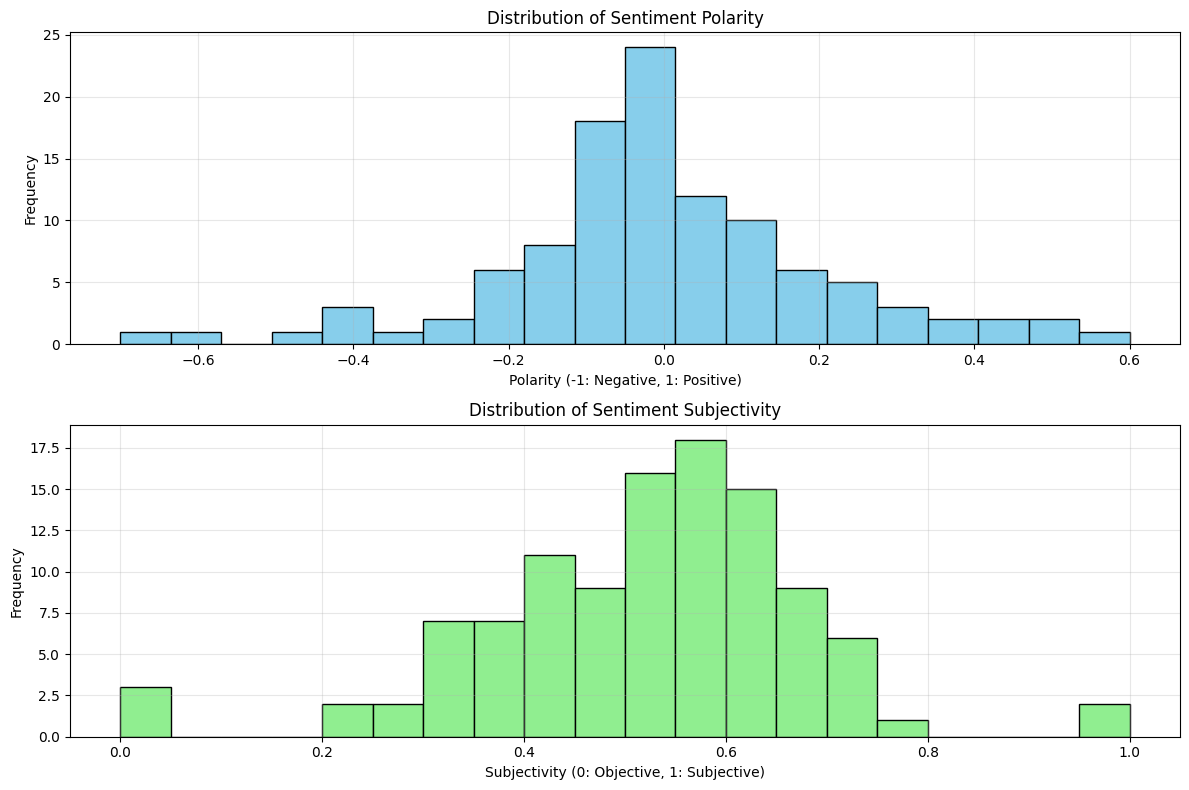

Average Polarity: -0.0010 (-1: Negative, 1: Positive)
Average Subjectivity: 0.5199 (0: Objective, 1: Subjective)


In [22]:
from textblob import TextBlob

#lets do a little example with the first review
review = df.iloc[0]
print(review['comment'])

#lets get the 'TextBlob' of the review
wiki = TextBlob(review['comment'])
print(wiki.noun_phrases)

#lets get the sentiment of the review
sentiment = wiki.sentiment
print(sentiment) 
#this is a tuple with the polarity and subjectivity
#polarity is a float between -1 and 1, with 1 indicating a very positive sentiment and -1 indicating a very negative sentiment
#subjectivity is a float between 0 and 1, with 0 indicating a very objective sentiment and 1 indicating a very subjective sentiment

df['sentiment'] = df['comment'].apply(lambda x: TextBlob(x).sentiment)
print(df['sentiment'])

# Extract polarity and subjectivity from sentiment tuples
df['polarity'] = df['sentiment'].apply(lambda x: x[0])
df['subjectivity'] = df['sentiment'].apply(lambda x: x[1])

# Create a figure with two subplots
plt.figure(figsize=(12, 8))

# Plot polarity distribution
plt.subplot(2, 1, 1)
plt.hist(df['polarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Polarity (-1: Negative, 1: Positive)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Plot subjectivity distribution
plt.subplot(2, 1, 2)
plt.hist(df['subjectivity'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Subjectivity (0: Objective, 1: Subjective)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display average sentiment metrics
avg_polarity = df['polarity'].mean()
avg_subjectivity = df['subjectivity'].mean()
print(f"Average Polarity: {avg_polarity:.4f} (-1: Negative, 1: Positive)")
print(f"Average Subjectivity: {avg_subjectivity:.4f} (0: Objective, 1: Subjective)")


In [ ]:
#Give our own teacher rating
'''
Possible factors
Quality score
Difficulty score
Tag Score
Overall Sentiment score
Extractive summarization sentiment
Would Take again %
Interaction Score
'''